In [170]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


#maintain consistent performance
tf.random.set_seed(42)
np.random.seed(42)

#confirm GPU is available
print("num GPUs:", len(tf.config.list_physical_devices('GPU')))

num GPUs: 1


In [171]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [172]:
dset = pd.read_csv('/content/drive/MyDrive/CData/emnist-balanced-train.csv', header=None)
dset.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,45,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,36,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,43,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,15,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [173]:
dset.describe()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
count,112800.00000,112800.0,112800.0,112800.0,112800.0,112800.000000,112800.000000,112800.000000,112800.000000,112800.000000,...,112800.000000,112800.0,112800.0,112800.000000,112800.000000,112800.0,112800.0,112800.0,112800.0,112800.0
mean,23.00000,0.0,0.0,0.0,0.0,0.001365,0.011560,0.020700,0.017438,0.018475,...,0.000310,0.0,0.0,0.002163,0.000284,0.0,0.0,0.0,0.0,0.0
std,13.56472,0.0,0.0,0.0,0.0,0.235046,1.221826,1.658797,1.602478,1.719549,...,0.104211,0.0,0.0,0.726499,0.095279,0.0,0.0,0.0,0.0,0.0
min,0.00000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
25%,11.00000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
50%,23.00000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
75%,35.00000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
max,46.00000,0.0,0.0,0.0,0.0,63.000000,192.000000,217.000000,217.000000,217.000000,...,35.000000,0.0,0.0,244.000000,32.000000,0.0,0.0,0.0,0.0,0.0


112800 rows (images), each described using 784 variables 28x28 pixels plus one column as output variable (first col).

In [174]:
dset.shape

(112800, 785)

In [175]:
# split dataset
dset = dset.loc[:,1:]
dset.shape

(112800, 784)

<function matplotlib.pyplot.show(*args, **kw)>

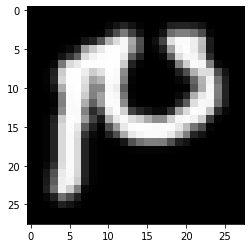

In [176]:
# normalize data
dset = np.expand_dims(dset,-1).astype('float32')/255
# reshape images to 28 x 28
dset = np.reshape(dset,(-1,28,28))
# get sample image to see what they look like
sample = dset[102]
plt.imshow(sample, cmap=plt.cm.gray)
plt.show

Image is rotated. To fix this, we have to flip it horizontally and rotate it 90 degrees anti-clockwise.
(https://stackoverflow.com/questions/48532761/letters-in-emnist-training-dataset-are-rotated-and-little-vague)

In [177]:
def rotate(sample):
  sample = np.fliplr(sample)
  sample = np.rot90(sample)
  return sample


<function matplotlib.pyplot.show(*args, **kw)>

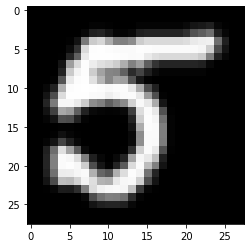

In [178]:
# Check if the rotate function worked
s1 = rotate(sample)
plt.imshow(s1, cmap=plt.cm.gray)
plt.show

In [179]:
dset = [rotate(x) for x in dset]

<function matplotlib.pyplot.show(*args, **kw)>

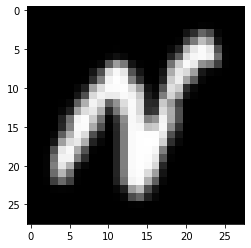

In [180]:
import random
# check if function worked for the whole dataset by looking at random element
r = random.randint(100, 1000)
s2 = dset[r]
plt.imshow(s2, cmap=plt.cm.gray)
plt.show

Dataset might be too big for GAN (more than 100,000 images), the ideal range according to NVIDIA is from 50,000 to 100,000.

In [181]:
dset = dset[:60000] 

Reshape data to dimensions needed by CNN layers, shuffle, and batch it.

In [182]:
BATCH_SIZE = 64
# convolution layers work 3 channels 
dset = np.reshape(dset,(-1,28,28,1))
# tensorflow dataset obj
dset =  tf.data.Dataset.from_tensor_slices(dset)
# set batch size for it not to read one image at a time
dset = dset.shuffle(buffer_size=1024).batch(BATCH_SIZE)

Set up model for generator. Three COnv2DTranspose layers are used to construct the images.

In [183]:
# Generator's input is a noise vector hyperparameter (fine-tune later)
NOISE_DIM = 150
#used to be 150
# design generator model with unsampling layers
generator = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(NOISE_DIM,)),
    layers.Dense(7*7*256),
    layers.Reshape(target_shape=(7,7,256)),
    # Three COnv2DTranspose layers are used to construct the images. Similar to VAE.
    layers.Conv2DTranspose(256,3,activation="LeakyReLU",strides=2,padding="same"),
    layers.Conv2DTranspose(128,3,activation="LeakyReLU",strides=2,padding="same"),
    layers.Conv2DTranspose(1,3,activation="sigmoid",padding="same")
])

generator.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 12544)             1894144   
                                                                 
 reshape_8 (Reshape)         (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose_21 (Conv2D  (None, 14, 14, 256)      590080    
 Transpose)                                                      
                                                                 
 conv2d_transpose_22 (Conv2D  (None, 28, 28, 128)      295040    
 Transpose)                                                      
                                                                 
 conv2d_transpose_23 (Conv2D  (None, 28, 28, 1)        1153      
 Transpose)                                                      
                                                     

Use untrained generator to create an image

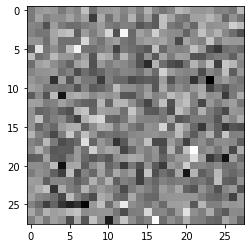

In [184]:
noise = tf.random.normal([1,NOISE_DIM])
new_image = generator(noise, training=False)
plt.imshow(new_image[0,:,:,0], cmap=plt.cm.gray)

Create discriminator model. Two Conv2D layers to downsample before going into a 64-neuron dense layer and a dropout to avoid overfitting. The output is binary, as the job is to classify the character images as real or fake until it cannot tell the difference anymore.

In [185]:
# create discriminator
discriminator = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(28,28,1)),
    # activation parameters were chosen on the basis that they are standard practice in GANs.
    layers.Conv2D(256,3,activation="relu", strides=2,padding="same"),
    layers.Conv2D(128,3,activation="relu", strides=2,padding="same"),
    layers.Flatten(),
    layers.Dense(64,activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(1,activation="sigmoid")
])

discriminator.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 14, 14, 256)       2560      
                                                                 
 conv2d_15 (Conv2D)          (None, 7, 7, 128)         295040    
                                                                 
 flatten_7 (Flatten)         (None, 6272)              0         
                                                                 
 dense_21 (Dense)            (None, 64)                401472    
                                                                 
 dropout_9 (Dropout)         (None, 64)                0         
                                                                 
 dense_22 (Dense)            (None, 1)                 65        
                                                                 
Total params: 699,137
Trainable params: 699,137
Non-t

Set up optimizers, loss functions, and accuracy metrics. Hyperparameters to get the learning rates well in the generator and discriminator for the sake of stability.

In [186]:
# optimizers
G_optimizer = keras.optimizers.Adam(learning_rate=0.00001, beta_1=0.5)
D_optimizer = keras.optimizers.Adam(learning_rate=0.00003, beta_1=0.5)

# binary classifier
loss_fn = keras.losses.BinaryCrossentropy(from_logits=True)

# accuracy metric
gAccMetric = tf.keras.metrics.BinaryAccuracy()
dAccMetric = tf.keras.metrics.BinaryAccuracy()

Define training function for one step of generator and one of the discriminator

In [190]:
@tf.function
def trainStep(x):
    # batch (32,28,28,1). Extract 32 value
    batch = tf.shape(x)[0]
    noise = tf.random.normal([batch,NOISE_DIM])
    # concatenate labels
    trD = tf.concat([
        # real labeled with 1
        tf.ones(batch, 1),
        # fake labeled with 0
        tf.zeros(batch,1)
    ], axis=0)
    trG = tf.ones(batch)
    
    with tf.GradientTape() as gTape, tf.GradientTape() as dTape:
        # test the outcome of generator
        gen = generator(noise)
        fakeO = discriminator(gen)
        realO = discriminator(x)

        # make discriminator detect the difference between real and fake data
        pred = discriminator(tf.concat([x,gen],axis=0))

        # calculate loss
        genLoss = loss_fn(trG,fakeO)
        disLoss = loss_fn(trD,pred)
    # apply backpropagation and update weights
    grG = gTape.gradient(genLoss, generator.trainable_weights)
    grD = dTape.gradient(disLoss,discriminator.trainable_variables)
    G_optimizer.apply_gradients(zip(grG,generator.trainable_weights))
    D_optimizer.apply_gradients(zip(grD,discriminator.trainable_variables))
    # accuracy
    gAccMetric.update_state(trG,fakeO)
    dAccMetric.update_state(trD,pred)
    

    # return loss for visualization
    return {
        # loss
        "gen loss": genLoss,
        "dis loss": disLoss,
        # accuracy
        "gen acc": gAccMetric.result(),
        "dis acc": dAccMetric.result()
    }